## Tutorial
# Parallel Self Play with Ray!

In [1]:
import numpy as np
import ray
from pickle import Unpickler

from alphazero.interfaces import PolicySpec, MctsParams
from alphazero.game_data import read_training_data
from alphazero import tools as gt
from alphazero.utils import Timer
from alphazero.ray.trainer import create_pool, PolicyRef
from alphazero.gomoku_game import RandomBoardInitializer, GomokuGame
from alphazero.policies.ray_impl import HeuristicRayPolicy
from alphazero.self_play import SelfPlay

In [2]:
BOARD_SIZE=15

In [3]:
rctx = ray.init(ignore_reinit_error=True)

2022-08-03 21:00:34,322	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265


In [4]:
params = MctsParams(
    cpuct = 1.0,
    num_simulations=100,
    model_threshold=.2)

# Number of self-play workers
N_SP = 8

# Number of policy workers
N_P = 8

rbi = RandomBoardInitializer(BOARD_SIZE, 4, 5, 9, 5, 9)
game = GomokuGame(BOARD_SIZE, rbi)

## Setting up the zoo of actors
A pool of selp-play actors feeding into a round-robin dispatcher serving a fixed number of policy workers. That's a maximum of as many policy workers as there are non-shareable (GPU) resources.

In [42]:
dispatcher = create_pool(num_workers=N_P, policy=HeuristicRayPolicy(),
                         board_size=BOARD_SIZE, cut_off = 0.5)
selfplays = [SelfPlay.remote(mcts_params=params) for _ in range(N_SP)]
for selfplay in selfplays:
    selfplay.init.remote(BOARD_SIZE, game, PolicySpec(pool_ref=PolicyRef(dispatcher)))

(PolicyWorker pid=56771) 2022-08-04 14:23:46.768707: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
(PolicyWorker pid=56771) To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
(PolicyWorker pid=56771) /Users/wgiersche/.local/share/virtualenvs/DeepGomoku-cXtJ_EtM/lib/python3.10/site-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
(PolicyWorker pid=56771)   result = asarray(a).shape
(PolicyWorker pid=56783) 2022-08-04 14:23:50.704319: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized

In [6]:
selfplay_pool = ray.util.ActorPool(selfplays)

---
# Creating fully expanded, ready-to-learn examples

These are all symmetries of all tuples $(s, p, v)$, like (state: 17x17x3, policy: float 225, v: float)


---
### Skip this section if you want to write into files
---

In [7]:
res = selfplay_pool.map(lambda a, _: a.observe_trajectory.remote(), range(36))

In [8]:
with Timer(verbose=True):
    res = [t for t in res]

(SelfPlay pid=85919) 2022-08-03 20:21:25.462427: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
(SelfPlay pid=85919) To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
(SelfPlay pid=85927) 2022-08-03 20:21:25.460783: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
(SelfPlay pid=85927) To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
(SelfPlay pid=85927) /Users/wgiersche/.local/share/virtualenvs/DeepGomoku-cXtJ_EtM/lib/python3.10/site-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a 

elapsed time: 1406462.330618 ms


---
# Validate the result

The number of games

In [9]:
len(res)

36

A particular game

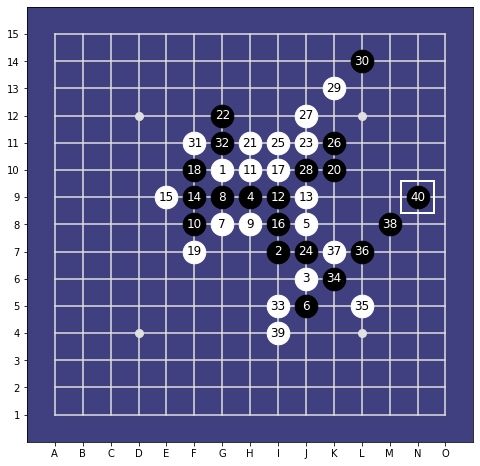

In [13]:
examples, stones = res[3]
from domoku.board import GomokuBoard as LegacyBoard
from alphazero.gomoku_board import GomokuBoard
the_board = GomokuBoard(15, stones)
stones_str = "".join([f"{the_board.Stone(i)}" for i in stones])
db = LegacyBoard(15, stones=stones_str, disp_width=8)
db.display();

Each game comes with (N-4)*8 positions. The first 4 moves are made by the random initializer and have thus not been processed by the MCTS. The factor of 8 comes from the symmetries.

In [14]:
len(examples)

288

Each position consists of a 17x17x3 state, a policy evaluation of 15x15=225 move probabilities and a value estimate. Policy evaluation and value estimate are the results of the MCTS computations. They'll be used to improve the player's intuition (train the policy/value network)

In [21]:
last_state = None
for i in range(len(examples) // 8):
    s, p, v = examples[i*8+7]
    s_ = np.array(stones[:i+4+1], dtype=np.uint8)
    print(f"{i}: move={the_board.Stone(int(s_[-1]))}, value={v}")
    print(s_)
    gt.print_channels(s)
    p_ = (255 * np.array(p)).astype(np.uint8)
    print(p_.reshape(15, 15))
    if i==100:
        break
    print()
    last_state = s

0: move=F7, value=0.08346356004127779
[126  99 127 141 125]
shape: (17, 17, 3)
[[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]]
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 

In [14]:
policy = PolicyRef(dispatcher)

### Compare the last MCTS policy output to the original policy estimate

In [24]:
p, v = policy.predict(last_state)
p_ = (256 * np.array(p)).astype(np.uint8)
print(p_.reshape(15, 15))
print(f"Value: {float(v)}")

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 243   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   1   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]]
Value: 0.9297845572050805


---
# Saving examples for later training
Asking to provide trajectories 'for storage' significantly reduces the size of the data, as symmetries can be expanded when needed for training.

In [7]:
res = selfplay_pool.map(lambda a, _: a.observe_trajectory.remote(for_storage=True), range(40))

In [8]:
with Timer(verbose=True):
    res = [t for t in res]

(SelfPlay pid=91310) 2022-08-03 21:01:36.740145: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
(SelfPlay pid=91310) To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
(SelfPlay pid=91314) 2022-08-03 21:01:36.739164: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
(SelfPlay pid=91314) To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
(SelfPlay pid=91315) 2022-08-03 21:01:36.739244: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in perf

elapsed time: 1000624.940030 ms


In [13]:
from alphazero.gomoku_board import GomokuBoard
result = res[5][-2]
s, p, v = result
board = GomokuBoard(BOARD_SIZE, s)
board.plot()
print(p.reshape(15, 15))
print(f"Value: {v}")

                                                     
15    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
14    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
13    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
12    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
11    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
10    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
 9    .  .  .  .  .  .  .  O  .  .  .  .  .  .  .    
 8    .  .  .  .  .  X  .  .  .  O  .  .  .  .  .    
 7    .  .  .  .  .  .  X  X  .  X  O  .  .  .  .    
 6    .  .  .  .  .  O  X  X  X  O  .  .  .  .  .    
 5    .  .  .  .  .  .  O  X  O  .  .  .  .  .  .    
 4    .  .  .  .  .  .  O [X] .  .  .  .  .  .  .    
 3    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
 2    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
 1    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
                                                     
      A  B  C  D  E  F  G  H  I  J  K  L  M  N  O
[[  0   0   0   0   0   0   0   

In [14]:
from pickle import Pickler

filename = "./40_games.pickle"
with open(filename, "wb+") as f:
    Pickler(f).dump(res)

In [15]:
!ls -lt ./*games.pickle

-rw-r--r--  1 wgiersche  staff  337899 Aug  3 21:19 ./40_games.pickle
-rw-r--r--  1 wgiersche  staff   11772 Aug  3 19:07 ./games.pickle
-rw-r--r--  1 wgiersche  staff  291960 Aug  3 13:57 ./all_games.pickle


---
# Extracting and expanding training data

In [16]:
with open(filename, "rb") as f:
    data = Unpickler(f).load()

In [17]:
result = data[0][0]

In [18]:
stones, p, v = result
#stones = [int(stone) for stone in stones]

In [19]:
board = GomokuBoard(BOARD_SIZE, stones)
board.plot()
print(p.reshape(15,15))

                                                     
15    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
14    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
13    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
12    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
11    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
10    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
 9    .  .  .  .  .  .  .  .  .  O  .  .  .  .  .    
 8    .  .  .  .  .  X [O] .  .  .  .  .  .  .  .    
 7    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
 6    .  .  .  .  .  .  .  X  .  .  .  .  .  .  .    
 5    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
 4    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
 3    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
 2    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
 1    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
                                                     
      A  B  C  D  E  F  G  H  I  J  K  L  M  N  O
[[  0   0   0   0   0   0   0   

In [20]:
game = GomokuGame(BOARD_SIZE, rbi)
sym = game.get_symmetries(board.canonical_representation(), p)
for b, p_ in sym:
    gt.print_channels(b)
    print(np.reshape(p_, (15,15)))

shape: (17, 17, 3)
[[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]]
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   

In [21]:
examples = read_training_data(filename, BOARD_SIZE)

In [32]:
np.shape(examples[0])

/Users/wgiersche/.local/share/virtualenvs/DeepGomoku-cXtJ_EtM/lib/python3.10/site-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


(3,)

In [22]:
len(examples)

8120

In [71]:
s, p, v = examples[0]
gt.print_channels(s)

shape: (17, 17, 3)
[[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]]
